# PyTorch and bag-of-words

Here I use the bag-of-words method and a PyTorch neural network to build the model.

## Set up environment

### Download dataset manually

Let's start downloading the train dataset from Kaggle's website:

https://www.kaggle.com/c/nlp-getting-started/data

I downloaded the dataset manually and saved if in the 'input' folder.

The dataset could be downloaded programmatically using Kaggle API, but it requires authentication and it would be unsafe on a notebook that is meant to be shared.

### Read dataset from CSV

Read the dataset from the CSV file.

In [75]:
import numpy as np
import pandas as pd

# Read train dataset
train_df = pd.read_csv('input/train.csv', encoding = 'ISO-8859-1', index_col='id')
train_labels = train_df.pop('target').tolist()

# Read test dataset
test_df = pd.read_csv('input/test.csv', encoding = 'ISO-8859-1', index_col='id')

# Check
train_df.head()

,keyword,location,text
id,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
4,NaN,NaN,Forest fire near La Ronge Sask. Canada
5,NaN,NaN,All residents asked to 'shelter in place' are ...
6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


## Text tokenization

Tweets are tokenized in a multi-step process:
1. **Remove hyperlinks:** Replace hyperlinks with the keyword “islink”.
1. **Numbers:** Replace all numbers with the keyword “isnumber”.
1. **Punctuation:** Remove any non-alphanumeric character.
1. **Case:** Make all tweets lowercase.
1. **Split** text into different words.
1. **Remove stopwords**.
1. **Stem words**.

I use the _Natural Language Toolkit_ and _Regular Expressions_ to tokenize tweets.

In [58]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re

def tweet_to_words(text):
    nltk.download('stopwords', quiet=True)
    stemmer = PorterStemmer()

    text = re.sub(r'http\S+', ' islink ', text) # replace hyperlinks with keyword
    text = re.sub(r'(?!,$)[\d,.]+', ' isnumber ', text) # replace numbers with keyword
    text = re.sub(r'[^a-zA-Z0-0]', ' ', text.lower()) # Remove non-alphanumeric characters and convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

In [80]:
# Train dataset
words = []
for index, row in train_df.iterrows():
    words.append(tweet_to_words(row['text']))

train_df['words'] = words

# Test dataset
words = []
for index, row in test_df.iterrows():
    words.append(tweet_to_words(row['text']))

test_df['words'] = words

words = [] # Free words

train_df.head() # Check

,keyword,location,text,words
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,"[deed, reason, earthquak, may, allah, forgiv, us]"
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, rong, sask, isnumb, c..."
5,NaN,NaN,All residents asked to 'shelter in place' are ...,"[resid, ask, shelter, place, notifi, offic, is..."
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...","[isnumb, peopl, receiv, wildfir, evacu, order,..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,"[got, sent, photo, rubi, alaska, smoke, wildfi..."


## Build vocabulary

Create a vocabulary using the tokens found in the train dataset

In [61]:
# Create word dictionary
def build_vocabulary(data, vocabulary_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # TODO: Determine how often each word appears in `data`. Note that `data` is a list of sentences and that a
    #       sentence is a list of words.
    
    word_count = {} # A dict storing the words that appear in the reviews along with how often they occur
    for sentence in data:
        for word in sentence:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
                
    # TODO: Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    #       sorted_words[-1] is the least frequently appearing word.
    
    import operator
    
    sorted_words = None
    sorted_words = [item[0] for item in sorted(word_count.items(), key=lambda x: x[1], reverse=True)]
        
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocabulary_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict, word_count

In [62]:
# Build dictionary
vocabulary_size = 3000
word_vocabulary, word_count = build_vocabulary(train_df['words'], vocabulary_size=vocabulary_size)

# dict size
print("Vocabulary size:", len(word_vocabulary))

# Ten most frequently appearing words in the training set.
n = 0
for word in word_vocabulary:
    print(word_count[word], word)
    if n > 10:
        break
    n += 1

Vocabulary size: 3058
8096 isnumb
4721 islink
411 like
363 fire
344 amp
311 get
239 bomb
228 new
220 via
213 news
209 one
204 go


Let's find out a little bit more about the vocabulary distribution and make sure we picked the right vocabulary size.

Total number of words found: 13066
Number of words found 4 times or more: 2956


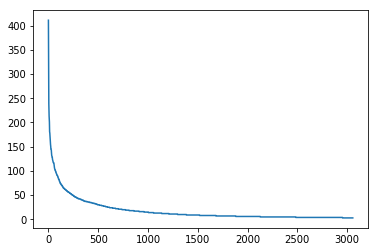

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

# Count how many different words are found in tweets
word_count_list = []
for key, value in word_count.items():
    word_count_list.append(value)
print('Total number of words found:', len(word_count_list))

# Plot the distribution of words
plt.plot(sorted(word_count_list, reverse=True)[2:vocabulary_size])

# Find whow many words are found N times or more
word_threshold = 4
word_count_list = [word_count for word_count in word_count_list if word_count >= word_threshold]

print('Number of words found', str(word_threshold), 'times or more:', len(word_count_list))

## Codification of tokens

Turn tweets into an array of numbers where each number is a word in the vocabulary. Also, the algorithm needs all tweets to be the same length, so we need to choose a tweet length and pad those that are shorter with "NOWORD".

In [64]:
def convert_and_pad(word_dict, sentence, pad=15):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=15):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

### Choose the right length

In order to save some RAM, I am not looking to cover the length of the longest tweet, but the vast majority.

In [65]:
lengths = []
for sentence in train_df['words']:
    lengths.append(len(sentence))
    
percentile = 99.9
padded_length = int(np.percentile(lengths, percentile))
print('To cover', percentile, '% of tweets the right length is:', padded_length)
print('The longest tweet is', len(max(train_df['words'], key=len)), 'words long')

To cover 99.9 % of tweets the right length is: 26
The longest tweet is 32 words long


### Codification

In [81]:
train_x, train_x_len = convert_and_pad_data(word_vocabulary, train_df['words'], pad=padded_length)
test_x, test_x_len = convert_and_pad_data(word_vocabulary, test_df['words'], pad=padded_length)

Check that conversion went well.

In [67]:
idx = np.random.randint(len(train_df))
print('Index generated randomly:', idx)
print('Original text:', train_df.iloc[idx]['text'])
print('Tokenized:', train_df.iloc[idx]['words'])
print('Codified:', train_x[idx])

Index generated randomly: 530
Original text: I saw two great punk bands making original music last week. Check em out here!! @GHOSTOFTHEAV @MontroseBand https://t.co/WdvxjsQwic
Tokenized: ['saw', 'two', 'great', 'punk', 'band', 'make', 'origin', 'music', 'last', 'week', 'isnumb', 'check', 'em', 'ghostoftheav', 'montroseband', 'islink']
Codified: [ 397   67  169    1 1746   36 1094  495  100  271    2  227  786    1
    1    3    0    0    0    0    0    0    0    0    0    0]


## Save data to train the model

### Save vocabulary

In [68]:
import os
import pickle

data_dir = 'data' # The folder we will use for storing data
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)

with open(os.path.join(data_dir, 'word_vocab.pkl'), "wb") as f:
    pickle.dump(word_vocabulary, f)

### Save training dataset

Save the post-processed training dataset

In [69]:
pd.concat([pd.DataFrame(train_labels), pd.DataFrame(train_x_len), pd.DataFrame(train_x)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Upload data so S3

In [71]:
# Upload data to S3
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/cp01'

role = sagemaker.get_execution_role()

input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

## Training the model

In [72]:
# Training the model

from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.m4.xlarge',
                    hyperparameters={
                        'epochs': 10,
                        'hidden_dim': 200,
                        'vocab_size': vocabulary_size
                    })

In [73]:
estimator.fit({'training': input_data})

2020-01-19 20:47:14 Starting - Starting the training job...
2020-01-19 20:47:16 Starting - Launching requested ML instances......
2020-01-19 20:48:17 Starting - Preparing the instances for training...
2020-01-19 20:48:59 Downloading - Downloading input data...
2020-01-19 20:49:43 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-19 20:49:44,373 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-19 20:49:44,375 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-19 20:49:44,388 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-19 20:49:44,392 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-19 20:49:44,615 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.p

## Deployment

In [74]:
# Deploy estimator

# Remember to shut down the endpoint when we are done!!!!

predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------------------------------------------------------!

## Testing

### Prepare test data

In [88]:
test_X = pd.concat([pd.DataFrame(test_x_len), pd.DataFrame(test_x)], axis=1)

,0,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,25
0,4,203,1711,57,21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,418,224,855,140,2,422,1277,194,2,...,0,0,0,0,0,0,0,0,0,0
2,12,148,5,612,2944,2,1,1,742,471,...,0,0,0,0,0,0,0,0,0,0
3,5,396,277,2,1,110,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,191,593,16,2,309,1048,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Predict

In [83]:
# We split the data into chunks and send each chunk seperately, accumulating the results.
def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [84]:
predictions = predict(test_X.values)
rounded_predictions = [round(num) for num in predictions]

### Save predictions for submission to Kaggle

Kaggle expects a 2-column CSV file. First column containing the _id_ and the second one our predicted _target_.

In [93]:
# Prepara dataframe
predictions_df = pd.DataFrame(rounded_predictions, index=test_df.index, columns=['target']).astype('int64')
predictions_df.head()

,target
id,
0,1
2,0
3,1
9,0
11,1


In [94]:
# Save to a .csv file
predictions_df.to_csv(r'data/predictions.csv', header=True)

A file with predictions has been saved in "data/predictions.csv". Now we can upload it to Kaggle manually and find out how it performed.